In [144]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, mean_absolute_error

In [145]:
# loading data from 2015-2025 into one dataframe

df = pd.concat(
    [pd.read_csv(f"data/atp_matches_{i}.csv") for i in range(2015, 2025)],
    ignore_index=True
)

df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2015-339,Brisbane,Hard,28,A,20150104,1,105357,NaN,WC,...,31.0,20.0,5.0,8.0,1.0,5.0,153.0,328.0,220.0,221.0
1,2015-339,Brisbane,Hard,28,A,20150104,2,103813,NaN,NaN,...,50.0,26.0,19.0,13.0,3.0,8.0,73.0,689.0,123.0,440.0
2,2015-339,Brisbane,Hard,28,A,20150104,3,105902,NaN,WC,...,37.0,22.0,5.0,8.0,10.0,15.0,125.0,430.0,21.0,1730.0
3,2015-339,Brisbane,Hard,28,A,20150104,4,104871,NaN,NaN,...,38.0,30.0,8.0,10.0,1.0,3.0,31.0,1195.0,72.0,691.0
4,2015-339,Brisbane,Hard,28,A,20150104,5,105373,NaN,NaN,...,62.0,40.0,19.0,15.0,4.0,8.0,34.0,1094.0,110.0,505.0


In [146]:
# Data Cleaning and Preprocessing
# we keep matches with a valid duration between 20 and 360 minutes (matches outside that range are extreme outliers and not representative)
df = df[df["minutes"].notna() & (df["minutes"] > 20) & (df["minutes"] < 360)]

# we remove retirements/ walkovers/ defaults if there is an entry in the column 'score'
if "score" in df.columns:
    df = df[~df["score"].str.contains("W/O|RET|DEF", na=False)]

# we create a list with numeric columns
numeric_cols = [
    "winner_rank", "loser_rank", "winner_age", "loser_age",
    "winner_seed", "loser_seed", "winner_ht", "loser_ht",
    "rank_diff", "age_diff", "height_diff", "seed_diff",
    "minutes", "round"
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")   #Wozu??

# we drop rows missing essential values
df = df.dropna(subset=["winner_rank", "loser_rank", "winner_age", "loser_age", "minutes", "best_of"])

print("Remaining rows:", len(df))

Remaining rows: 23956


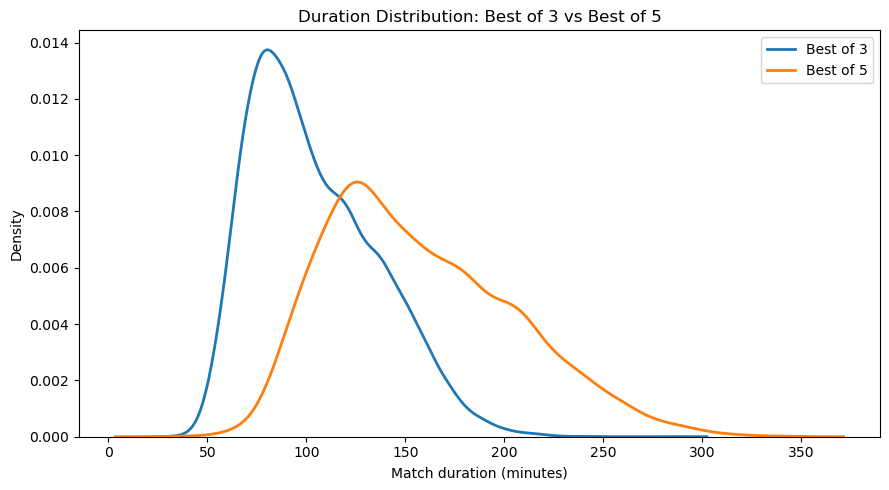

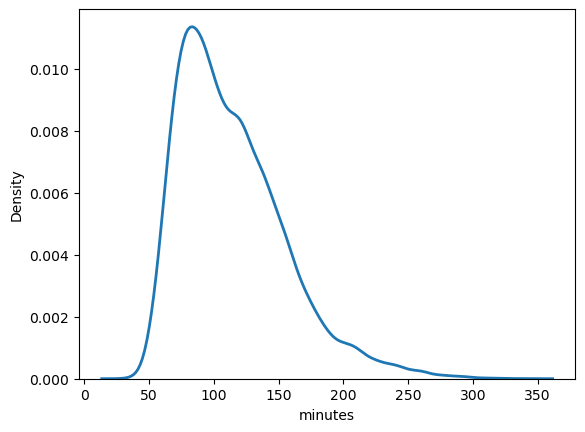

In [147]:
# Filter only rows that contain duration + best_of
df_plot = df[["minutes", "best_of"]].dropna()

plt.figure(figsize=(9, 5))

# Plot Bo3 separately
if 3 in df_plot["best_of"].unique():
    sns.kdeplot(
        df_plot[df_plot["best_of"] == 3]["minutes"],
        label="Best of 3",
        linewidth=2
    )

# Plot Bo5 separately
if 5 in df_plot["best_of"].unique():
    sns.kdeplot(
        df_plot[df_plot["best_of"] == 5]["minutes"],
        label="Best of 5",
        linewidth=2
    )

plt.xlabel("Match duration (minutes)")
plt.ylabel("Density")
plt.title("Duration Distribution: Best of 3 vs Best of 5")
plt.legend()
plt.tight_layout()
plt.show()

sns.kdeplot(df['minutes'], linewidth=2)
plt.show()

int64


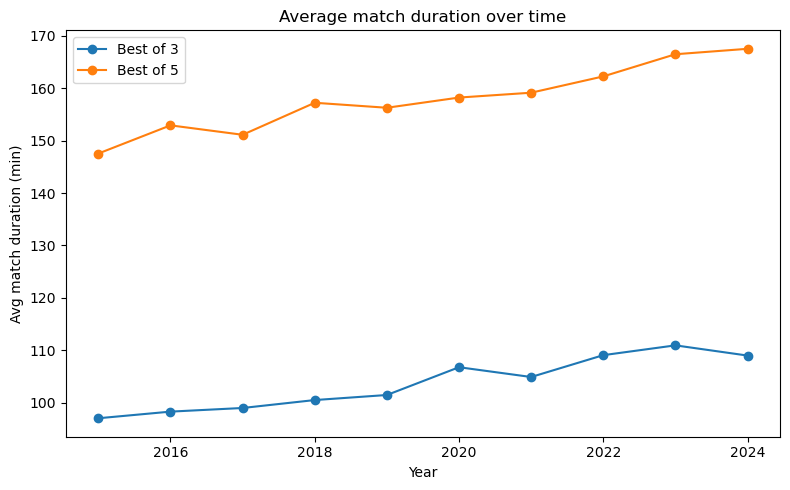

True
<bound method Index.unique of Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'year'],
      dtype='object')>


In [148]:
df['year'] = df['tourney_date'].astype(str).str[:4].astype(int)
print(df['year'].dtypes)
if "year" in df.columns and "best_of" in df.columns:
    trend = df.groupby(["year", "best_of"])['minutes'].mean().reset_index()

    plt.figure(figsize=(8, 5))
    for fmt, sub in trend.groupby("best_of"):
        plt.plot(sub["year"], sub['minutes'], marker="o", label=f"Best of {fmt}")
    plt.xlabel("Year")
    plt.ylabel("Avg match duration (min)")
    plt.title("Average match duration over time")
    plt.legend()
    plt.tight_layout()
    plt.show()
print("year" in df.columns)
print(df.columns.unique)

In [149]:
# feature engineering  

# Ranking features
df["rank_diff"] = (df["winner_rank"] - df["loser_rank"]).abs()
df["avg_rank"] = (df["winner_rank"] + df["loser_rank"]) / 2

# Age features
df["age_diff"] = (df["winner_age"] - df["loser_age"]).abs()
df["avg_age"] = (df["winner_age"] + df["loser_age"]) / 2

# Seed diff (as seeds are often non existent, we replace NaNs with 0s)
df["winner_seed"] = df["winner_seed"].fillna(0)
df["loser_seed"]  = df["loser_seed"].fillna(0)
df["seed_diff"]   = df["winner_seed"] - df["loser_seed"]

# Same country
df["same_country"] = (df["winner_ioc"] == df["loser_ioc"]).astype(int)

# Round mapping
round_map = {"R128":1, "R64":2, "R32":3, "R16":4, "QF":5, "SF":6, "F":7}
df["round"] = df["round"].map(round_map).fillna(3)

df.head()


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,winner_rank_points,loser_rank,loser_rank_points,year,rank_diff,avg_rank,age_diff,avg_age,seed_diff,same_country
0,2015-339,Brisbane,Hard,28,A,20150104,1,105357,0.0,WC,...,328.0,220.0,221.0,2015,67.0,186.5,1.8,24.60,0.0,0
1,2015-339,Brisbane,Hard,28,A,20150104,2,103813,0.0,NaN,...,689.0,123.0,440.0,2015,50.0,98.0,11.1,27.85,0.0,0
2,2015-339,Brisbane,Hard,28,A,20150104,3,105902,0.0,WC,...,430.0,21.0,1730.0,2015,104.0,73.0,7.1,26.45,-6.0,0
3,2015-339,Brisbane,Hard,28,A,20150104,4,104871,0.0,NaN,...,1195.0,72.0,691.0,2015,41.0,51.5,0.4,27.60,0.0,0
4,2015-339,Brisbane,Hard,28,A,20150104,5,105373,0.0,NaN,...,1094.0,110.0,505.0,2015,76.0,72.0,8.2,29.50,0.0,0


In [150]:
# Prepareing features for modeling

# One-hot encode surface & tourney level
df = pd.get_dummies(df, columns=["surface"], prefix="surface")
df = pd.get_dummies(df, columns=["tourney_level"], prefix="tourney_level")

# Expected dummy columns
surface_cols = ["surface_Clay", "surface_Grass", "surface_Hard"]
tourney_cols = ["tourney_level_A", "tourney_level_G", "tourney_level_M"]

# we add missing columns with zeros
for col in surface_cols + tourney_cols:
    if col not in df.columns:
        df[col] = 0

# Final feature list
feature_cols = [
    "rank_diff", "avg_rank",
    "age_diff", "avg_age", "same_country",
    "round"
] + surface_cols + tourney_cols

# we fill missing values
df[feature_cols] = df[feature_cols].fillna(0)

df[feature_cols].head()


,rank_diff,avg_rank,age_diff,avg_age,same_country,round,surface_Clay,surface_Grass,surface_Hard,tourney_level_A,tourney_level_G,tourney_level_M
0,67.0,186.5,1.8,24.60,0,3.0,False,False,True,True,False,False
1,50.0,98.0,11.1,27.85,0,3.0,False,False,True,True,False,False
2,104.0,73.0,7.1,26.45,0,3.0,False,False,True,True,False,False
3,41.0,51.5,0.4,27.60,0,3.0,False,False,True,True,False,False
4,76.0,72.0,8.2,29.50,0,3.0,False,False,True,True,False,False


In [151]:
# Split by format
df_bo3 = df[df["best_of"] == 3].copy()
df_bo5 = df[df["best_of"] == 5].copy()

# Features
features = [
    'rank_diff','avg_rank','avg_age',
    'age_diff','round','same_country'
]
features += [col for col in df_bo3.columns if 'surface_' in col or 'tourney_level_' in col]

X3, y3 = df_bo3[features], df_bo3['minutes']
X5, y5 = df_bo5[features], df_bo5['minutes']

X3 = X3.fillna(X3.mean())
X5 = X5.fillna(X5.mean())

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=42)

# Linear Regression model

model3 = LinearRegression().fit(X3_train, y3_train)
model5 = LinearRegression().fit(X5_train, y5_train)

y3_pred = model3.predict(X3_test)
y5_pred = model5.predict(X5_test)

print("Bo3 R²:", r2_score(y3_test, y3_pred))
print("Bo3 MAE:", mean_absolute_error(y3_test, y3_pred))
print("Bo5 R²:", r2_score(y5_test, y5_pred))
print("Bo5 MAE:", mean_absolute_error(y5_test, y5_pred))


Bo3 R²: 0.01255253833339598
Bo3 MAE: 26.419252503972995
Bo5 R²: 0.03312678048098361
Bo5 MAE: 37.91335029938959


In [152]:
# RF model for Best-of-3
rf3_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
).fit(X3_train, y3_train)

# RF model for Best-of-5
rf5_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
).fit(X5_train, y5_train)

# Predictions
rf3_pred = rf3_model.predict(X3_test)
rf5_pred = rf5_model.predict(X5_test)

# Evaluation
print("RF Bo3 R²:", r2_score(y3_test, rf3_pred))
print("RF Bo3 MAE:", mean_absolute_error(y3_test, rf3_pred))

print("RF Bo5 R²:", r2_score(y5_test, rf5_pred))
print("RF Bo5 MAE:", mean_absolute_error(y5_test, rf5_pred))


RF Bo3 R²: 0.004094605735177392
RF Bo3 MAE: 26.519802913403797
RF Bo5 R²: 0.0029046770785479126
RF Bo5 MAE: 38.51078642240856


In [153]:
# Prediction function (we use Linear Regression as it performes best)
# we store feature names after training
model3_features = list(X3.columns)
model5_features = list(X5.columns)

def predict_match_duration(rank1, rank2, age1, age2, surface, tourney_level, round_code, best_of, country1, country2):

    # we select correct model + its feature list
    model = model3 if best_of == 3 else model5
    features = model3_features if best_of == 3 else model5_features

    # we create an empty row with all features initialized to 0
    row = pd.DataFrame({col: [0] for col in features})

    # Numeric Features 
    row.loc[0, "rank_diff"] = abs(rank1 - rank2)
    row.loc[0, "avg_rank"] = (rank1 + rank2) / 2

    row.loc[0, "age_diff"] = abs(age1 - age2)
    row.loc[0, "avg_age"] = (age1 + age2) / 2

    # Same country feature
    if "same_country" in features:
        row.loc[0, "same_country"] = int(country1 == country2)


    # Round feature
    round_map = {
        "R128": 1, "R64": 2, "R32": 3, "R16": 4,
        "QF": 5, "SF": 6, "F": 7
    }
    row.loc[0, "round"] = round_map.get(round_code, 3)

    # One-hot: Surface
    for surf in ["Clay", "Grass", "Hard"]:
        col = f"surface_{surf}"
        if col in features:
            row.loc[0, col] = int(surface == surf)

    # One-hot: Tournament level
    for lvl in ["A", "G", "M"]:
        col = f"tourney_level_{lvl}"
        if col in features:
            row.loc[0, col] = int(tourney_level == lvl)

    # Final prediction
    pred = float(model.predict(row)[0])

    print(f"Predicted match duration: {pred:.1f} minutes")
    return pred



In [154]:
# Example prediction

result = predict_match_duration(
    rank1=5,
    rank2=18,
    age1=27,
    age2=24,
    surface="Hard",
    tourney_level="A",
    round_code="QF",
    best_of=3,
    country1 = "USA",
    country2 = "USA"
)



Predicted match duration: 104.6 minutes


In [155]:
bo3_short = df_bo3["minutes"].quantile(0.25)   # 25th percentile
bo3_medium = df_bo3["minutes"].quantile(0.75)  # 75th percentile

print(bo3_short, bo3_medium)


79.0 126.0


In [156]:
bo5_short = df_bo5["minutes"].quantile(0.25)
bo5_medium = df_bo5["minutes"].quantile(0.75)

print(bo5_short, bo5_medium)


121.0 190.0


In [157]:
# creating duration classes

def classify_duration_bo3(minutes):
    """Classification thresholds for best-of-3 matches"""
    if minutes <= 79:
        return "Short"
    elif minutes <= 126:
        return "Medium"
    else:
        return "Long"

def classify_duration_bo5(minutes):
    """Classification thresholds for best-of-5 matches"""
    if minutes <= 121:
        return "Short"
    elif minutes <= 190:
        return "Medium"
    else:
        return "Long"

# Apply classification
df_bo3 = df[df["best_of"] == 3].copy()
df_bo5 = df[df["best_of"] == 5].copy()

df_bo3["duration_class"] = df_bo3["minutes"].apply(classify_duration_bo3)
df_bo5["duration_class"] = df_bo5["minutes"].apply(classify_duration_bo5)

print("BO3 class distribution:")
print(df_bo3["duration_class"].value_counts())

print("\nBO5 class distribution:")
print(df_bo5["duration_class"].value_counts())


BO3 class distribution:
duration_class
Medium    9576
Short     5039
Long      4718
Name: count, dtype: int64

BO5 class distribution:
duration_class
Medium    2302
Short     1177
Long      1144
Name: count, dtype: int64


In [158]:
# Preparing data
Xc_bo3 = df_bo3[feature_cols]
yc_bo3 = df_bo3["duration_class"]

Xc_bo5 = df_bo5[feature_cols]
yc_bo5 = df_bo5["duration_class"]

# Train/test split
Xc3_train, Xc3_test, yc3_train, yc3_test = train_test_split(
    Xc_bo3, yc_bo3, test_size=0.25, random_state=42
)
Xc5_train, Xc5_test, yc5_train, yc5_test = train_test_split(
    Xc_bo5, yc_bo5, test_size=0.25, random_state=42
)

# Train RandomForest models
clf3 = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
).fit(Xc3_train, yc3_train)

clf5 = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
).fit(Xc5_train, yc5_train)

# Evaluate
pred3 = clf3.predict(Xc3_test)
pred5 = clf5.predict(Xc5_test)

acc3 = accuracy_score(yc3_test, pred3)
acc5 = accuracy_score(yc5_test, pred5)

print("BO3 Classification Accuracy:", acc3)
print("BO5 Classification Accuracy:", acc5)


BO3 Classification Accuracy: 0.4913115432354158
BO5 Classification Accuracy: 0.4818339100346021


In [159]:
# confusion matrices

print("\n=== BO3 Confusion Matrix ===")
print(pd.DataFrame(
    confusion_matrix(yc3_test, pred3),
    index=["Short","Medium","Long"],
    columns=["Short","Medium","Long"]
))

print("\n=== BO5 Confusion Matrix ===")
print(pd.DataFrame(
    confusion_matrix(yc5_test, pred5),
    index=["Short","Medium","Long"],
    columns=["Short","Medium","Long"]
))



=== BO3 Confusion Matrix ===
        Short  Medium  Long
Short       7    1213    10
Medium      5    2335    26
Long        2    1203    33

=== BO5 Confusion Matrix ===
        Short  Medium  Long
Short      17     253     7
Medium     36     519    24
Long       10     269    21


In [160]:
def predict_match_class(rank1, rank2, age1, age2, surface, tourney_level, round_code, best_of, country1, country2):

    # choose correct model (clf3 for Bo3, clf5 for Bo5)
    clf = clf3 if best_of == 3 else clf5
    
    # Important: use the same feature structure as during training
    features = clf.feature_names_in_
    row = pd.DataFrame({col: [0] for col in features})

    # Ranking features
    row.loc[0, "rank_diff"] = abs(rank1 - rank2)
    row.loc[0, "avg_rank"]  = (rank1 + rank2) / 2

    # Age features
    row.loc[0, "age_diff"] = abs(age1 - age2)
    row.loc[0, "avg_age"]  = (age1 + age2) / 2
    
    # Same country 
    row.loc[0, "same_country"] = int(country1 == country2)

    # Round mapping (same mapping as training)
    round_map = {"R128":1, "R64":2, "R32":3, "R16":4, "QF":5, "SF":6, "F":7}
    row.loc[0, "round"] = round_map.get(round_code, 3)

    # Surface one-hot
    for s in ["Clay", "Grass", "Hard"]:
        col = f"surface_{s}"
        if col in features:
            row.loc[0, col] = int(surface == s)

    # Tournament Level one-hot
    for lvl in ["A", "G", "M"]:
        col = f"tourney_level_{lvl}"
        if col in features:
            row.loc[0, col] = int(tourney_level == lvl)

    # Predict class + probabilities
    class_pred = clf.predict(row)[0]
    class_probs = clf.predict_proba(row)[0]

    # Build probability dictionary
    prob_dict = dict(zip(clf.classes_, np.round(class_probs, 3)))

    print(f"Predicted Duration Class: {class_pred}")
    print(f"Class Probabilities: {prob_dict}")

    return class_pred, prob_dict



In [161]:
# Example classification prediction

result = predict_match_class(
    rank1 = 1,
    rank2 = 3,
    age1 = 21,
    age2 = 21,
    surface = "Hard",
    tourney_level = "G",
    round_code = "F",
    best_of = 5,
    country1="AUT",
    country2="AUT" 
)


Predicted Duration Class: Medium
Class Probabilities: {'Long': np.float64(0.36), 'Medium': np.float64(0.514), 'Short': np.float64(0.125)}


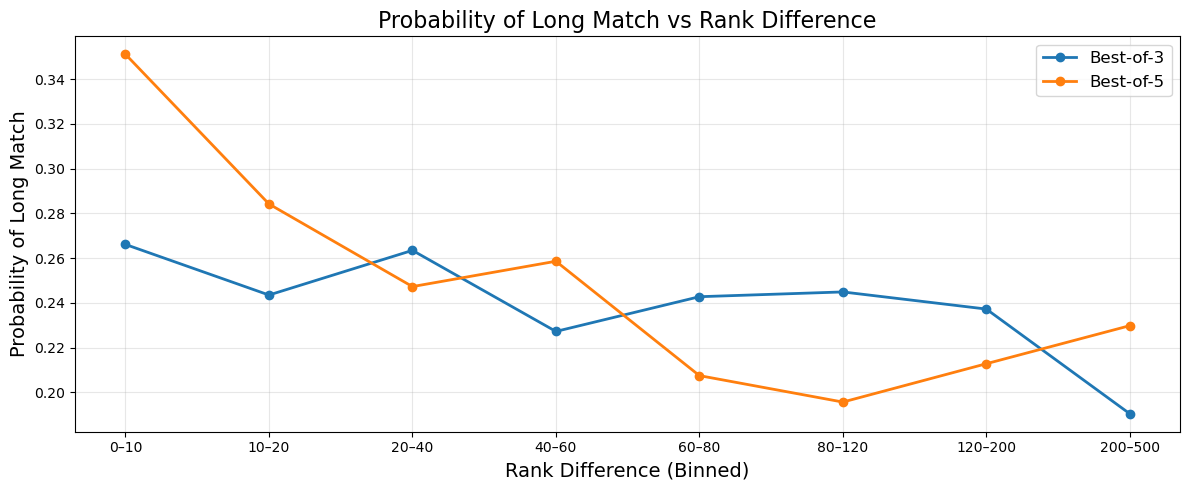

In [162]:
# Probability of Long Matches vs Rank Difference
# (Separated for Best-of-3 and Best-of-5)

# Define long match thresholds
df["is_long_bo3"] = ((df["best_of"] == 3) & (df["minutes"] > 126)).astype(int)
df["is_long_bo5"] = ((df["best_of"] == 5) & (df["minutes"] > 190)).astype(int)

# Create rank difference binning
df["rank_diff_bin"] = pd.cut(
    df["rank_diff"],
    bins=[0,10,20,40,60,80,120,200,500],
    labels=["0–10", "10–20", "20–40", "40–60", "60–80", "80–120", "120–200", "200–500"]
)

# Group by bins
bo3_probs = df[df["best_of"] == 3].groupby("rank_diff_bin")["is_long_bo3"].mean()
bo5_probs = df[df["best_of"] == 5].groupby("rank_diff_bin")["is_long_bo5"].mean()

# Plot
plt.figure(figsize=(12,5))
plt.plot(bo3_probs.index, bo3_probs.values, marker="o", label="Best-of-3", linewidth=2)
plt.plot(bo5_probs.index, bo5_probs.values, marker="o", label="Best-of-5", linewidth=2)

plt.title("Probability of Long Match vs Rank Difference", fontsize=16)
plt.xlabel("Rank Difference (Binned)", fontsize=14)
plt.ylabel("Probability of Long Match", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

